# Imports and Installs

In [1]:
!pip install yfinance

In [2]:
# read files shared via google-drive-link
# https://stackoverflow.com/questions/62759748/downloading-data-from-a-shared-google-drive-link-in-google-colab

!pip uninstall gdown -y && pip install gdown
!gdown -V

Found existing installation: gdown 5.1.0
Uninstalling gdown-5.1.0:
  Successfully uninstalled gdown-5.1.0
gdown 5.2.0 at /usr/local/lib/python3.10/dist-packages


In [3]:
# IMPORTS
import numpy as np
import pandas as pd

#Fin Data Sources
import yfinance as yf
import pandas_datareader as pdr

#Data viz
import plotly.graph_objs as go
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# measure time for ML HyperParams search
import time
from datetime import date

# ML models and utils
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

# Disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

# 0) One DataFrame with Dummies
* including newly defined "month-week_of_month"

## 0.1) Read and truncate data (last 25 years from 2000), define variable sets


In [4]:
# https://stackoverflow.com/questions/62759748/downloading-data-from-a-shared-google-drive-link-in-google-colab
# truncated data from Module 2: https://drive.google.com/file/d/1m3Qisfs2XfWk6Sw_Uk5kHLWqwQ0q8SKb/view?usp=sharing
!gdown https://drive.google.com/file/d/1kNWWPi49td0EZhmi6LzNCa2ssC5IUxHP/view?usp=sharing --fuzzy -O /content/

Downloading...
From (original): https://drive.google.com/uc?id=1kNWWPi49td0EZhmi6LzNCa2ssC5IUxHP
From (redirected): https://drive.google.com/uc?id=1kNWWPi49td0EZhmi6LzNCa2ssC5IUxHP&confirm=t&uuid=38f2d696-f86b-4624-9473-ae7251538b98
To: /content/stocks_df_combined_2024_05_07.parquet.brotli
100% 119M/119M [00:00<00:00, 122MB/s]


In [5]:
# truncated
# df = pd.read_parquet("/content/stocks_df_combined_trunc_2014_2023.parquet.brotli", )

# full dataset for 33 stocks
df_full = pd.read_parquet("/content/stocks_df_combined_2024_05_07.parquet.brotli", )

In [6]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 221142 entries, 0 to 5426
Columns: 202 entries, Open to growth_btc_usd_365d
dtypes: datetime64[ns](3), float64(128), int32(64), int64(5), object(2)
memory usage: 288.5+ MB


In [7]:
# growth indicators (but not future growth)
GROWTH = [g for g in df_full.keys() if (g.find('growth_')==0)&(g.find('future')<0)]
GROWTH

['growth_1d',
 'growth_3d',
 'growth_7d',
 'growth_30d',
 'growth_90d',
 'growth_365d',
 'growth_dax_1d',
 'growth_dax_3d',
 'growth_dax_7d',
 'growth_dax_30d',
 'growth_dax_90d',
 'growth_dax_365d',
 'growth_snp500_1d',
 'growth_snp500_3d',
 'growth_snp500_7d',
 'growth_snp500_30d',
 'growth_snp500_90d',
 'growth_snp500_365d',
 'growth_dji_1d',
 'growth_dji_3d',
 'growth_dji_7d',
 'growth_dji_30d',
 'growth_dji_90d',
 'growth_dji_365d',
 'growth_epi_1d',
 'growth_epi_3d',
 'growth_epi_7d',
 'growth_epi_30d',
 'growth_epi_90d',
 'growth_epi_365d',
 'growth_gold_1d',
 'growth_gold_3d',
 'growth_gold_7d',
 'growth_gold_30d',
 'growth_gold_90d',
 'growth_gold_365d',
 'growth_wti_oil_1d',
 'growth_wti_oil_3d',
 'growth_wti_oil_7d',
 'growth_wti_oil_30d',
 'growth_wti_oil_90d',
 'growth_wti_oil_365d',
 'growth_brent_oil_1d',
 'growth_brent_oil_3d',
 'growth_brent_oil_7d',
 'growth_brent_oil_30d',
 'growth_brent_oil_90d',
 'growth_brent_oil_365d',
 'growth_btc_usd_1d',
 'growth_btc_usd_3d',


In [8]:
# leaving only Volume ==> generate ln(Volume)
OHLCV = ['Open','High','Low','Close','Adj Close_x','Volume']

In [9]:
CATEGORICAL = ['Month', 'Weekday', 'Ticker', 'ticker_type']

In [10]:
df_full.growth_future_5d.describe()

count    220977.000000
mean          1.004630
std           0.051592
min           0.412383
25%           0.979594
50%           1.003802
75%           1.028273
max           3.018887
Name: growth_future_5d, dtype: float64

In [11]:
# 54% of data records have positive future growth>0
df_full.is_positive_growth_5d_future.mean()

0.5411319423718697

In [12]:
# moving to strong growth (54% -> ~ 32%)
df_full.growth_future_5d.quantile(0.68)

1.0202201074172228

In [13]:
# TODO HA4 Q3: Define a new variable 'is_strong_positive_growth_5d_future' according to the task
#  it will be automatically added the the list TO_PREDICT

In [14]:
TO_PREDICT = [g for g in df_full.keys() if (g.find('future')>=0)]
TO_PREDICT

['growth_future_5d', 'is_positive_growth_5d_future']

In [15]:
TO_DROP = ['Year','Date','index_x', 'index_y', 'index', 'Quarter','Adj Close_y'] + CATEGORICAL + OHLCV
TO_DROP

['Year',
 'Date',
 'index_x',
 'index_y',
 'index',
 'Quarter',
 'Adj Close_y',
 'Month',
 'Weekday',
 'Ticker',
 'ticker_type',
 'Open',
 'High',
 'Low',
 'Close',
 'Adj Close_x',
 'Volume']

In [16]:
# let's define on more custom numerical features
df_full['ln_volume'] = df_full.Volume.apply(lambda x: np.log(x))

In [17]:
# manually defined features
CUSTOM_NUMERICAL = ['SMA10', 'SMA20', 'growing_moving_average', 'high_minus_low_relative','volatility', 'ln_volume']

In [18]:
# All Supported Ta-lib indicators: https://github.com/TA-Lib/ta-lib-python/blob/master/docs/funcs.md

TECHNICAL_INDICATORS = ['adx', 'adxr', 'apo', 'aroon_1','aroon_2', 'aroonosc',
 'bop', 'cci', 'cmo','dx', 'macd', 'macdsignal', 'macdhist', 'macd_ext',
 'macdsignal_ext', 'macdhist_ext', 'macd_fix', 'macdsignal_fix',
 'macdhist_fix', 'mfi', 'minus_di', 'mom', 'plus_di', 'dm', 'ppo',
 'roc', 'rocp', 'rocr', 'rocr100', 'rsi', 'slowk', 'slowd', 'fastk',
 'fastd', 'fastk_rsi', 'fastd_rsi', 'trix', 'ultosc', 'willr',
 'ad', 'adosc', 'obv', 'atr', 'natr', 'ht_dcperiod', 'ht_dcphase',
 'ht_phasor_inphase', 'ht_phasor_quadrature', 'ht_sine_sine', 'ht_sine_leadsine',
 'ht_trendmod', 'avgprice', 'medprice', 'typprice', 'wclprice']

In [19]:
TECHNICAL_PATTERNS = [g for g in df_full.keys() if g.find('cdl')>=0]
print(f'Technical patterns count = {len(TECHNICAL_PATTERNS)}, examples = {TECHNICAL_PATTERNS[0:5]}')

Technical patterns count = 61, examples = ['cdl2crows', 'cdl3blackrows', 'cdl3inside', 'cdl3linestrike', 'cdl3outside']


In [20]:
MACRO = ['gdppot_us_yoy', 'gdppot_us_qoq', 'cpi_core_yoy', 'cpi_core_mom', 'FEDFUNDS',
 'DGS1', 'DGS5', 'DGS10']

In [21]:
NUMERICAL = GROWTH + TECHNICAL_INDICATORS + TECHNICAL_PATTERNS + CUSTOM_NUMERICAL + MACRO

In [22]:
# CHECK: NO OTHER INDICATORS LEFT
OTHER = [k for k in df_full.keys() if k not in OHLCV + CATEGORICAL + NUMERICAL + TO_DROP + TO_PREDICT]
OTHER

[]

In [23]:
df_full.Ticker.nunique()

33

In [24]:
# truncated df_full with 25 years of data (and defined growth variables)
df = df_full[df_full.Date>='2000-01-01']
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 182675 entries, 3490 to 5426
Columns: 203 entries, Open to ln_volume
dtypes: datetime64[ns](3), float64(129), int32(64), int64(5), object(2)
memory usage: 239.7+ MB


## 0.2) Dummies

In [25]:
# dummy variables can't be generated from Date and numeric variables ==> convert to STRING (to define groups for Dummies)
df.loc[:,'Month'] = df.Month.dt.strftime('%B')
df.loc[:,'Weekday'] = df.Weekday.astype(str)

### 0.2.1) Create a new string column 'month_wom' (month_week_of_month)

In [26]:
# define week of month
df.loc[:,'wom'] = df.Date.apply(lambda d: (d.day-1)//7 + 1)
# convert to string
df.loc[:,'wom'] = df.loc[:,'wom'].astype(str)

In [27]:
# check values for week-of-month (should be between 1 and 5)
df.wom.value_counts()

wom
2    42817
3    42007
4    41715
1    41490
5    14646
Name: count, dtype: int64

In [28]:
df.loc[:,'month_wom'] = df.Month + '_w' + df.wom

In [29]:
# examples of encoding
df.month_wom.value_counts()[0:2]

month_wom
February_w1    3705
January_w2     3686
Name: count, dtype: int64

In [30]:
# del wom temp variable
del df['wom']

### 0.2.2) Generate all dummies

In [31]:
# what are the categorical features?
CATEGORICAL.append('month_wom')
CATEGORICAL

['Month', 'Weekday', 'Ticker', 'ticker_type', 'month_wom']

In [32]:
# Generate dummy variables (no need for bool, let's have int32 instead)
dummy_variables = pd.get_dummies(df[CATEGORICAL], dtype='int32')

In [33]:
dummy_variables.info()

<class 'pandas.core.frame.DataFrame'>
Index: 182675 entries, 3490 to 5426
Columns: 115 entries, Month_April to month_wom_September_w5
dtypes: int32(115)
memory usage: 81.5 MB


In [34]:
# get dummies names in a list
DUMMIES = dummy_variables.keys().to_list()
DUMMIES

['Month_April',
 'Month_August',
 'Month_December',
 'Month_February',
 'Month_January',
 'Month_July',
 'Month_June',
 'Month_March',
 'Month_May',
 'Month_November',
 'Month_October',
 'Month_September',
 'Weekday_0',
 'Weekday_1',
 'Weekday_2',
 'Weekday_3',
 'Weekday_4',
 'Weekday_5',
 'Weekday_6',
 'Ticker_AAPL',
 'Ticker_ACN',
 'Ticker_AMZN',
 'Ticker_ASML',
 'Ticker_AVGO',
 'Ticker_BHARTIARTL.NS',
 'Ticker_BRK-B',
 'Ticker_CDI.PA',
 'Ticker_GOOG',
 'Ticker_HDB',
 'Ticker_HINDUNILVR.NS',
 'Ticker_IBN',
 'Ticker_IDEXY',
 'Ticker_INFY',
 'Ticker_ITC.NS',
 'Ticker_JPM',
 'Ticker_LICI.NS',
 'Ticker_LLY',
 'Ticker_LT.NS',
 'Ticker_MC.PA',
 'Ticker_META',
 'Ticker_MSFT',
 'Ticker_NVDA',
 'Ticker_NVO',
 'Ticker_OR.PA',
 'Ticker_RELIANCE.NS',
 'Ticker_RMS.PA',
 'Ticker_SAP',
 'Ticker_SBIN.NS',
 'Ticker_SIE.DE',
 'Ticker_TCS.NS',
 'Ticker_TTE',
 'Ticker_V',
 'ticker_type_EU',
 'ticker_type_INDIA',
 'ticker_type_US',
 'month_wom_April_w1',
 'month_wom_April_w2',
 'month_wom_April_w3',
 'mo

In [35]:
len(DUMMIES)

115

In [36]:
# Concatenate the dummy variables with the original DataFrame
df_with_dummies = pd.concat([df, dummy_variables], axis=1)

In [37]:
df_with_dummies[NUMERICAL+DUMMIES].info()

<class 'pandas.core.frame.DataFrame'>
Index: 182675 entries, 3490 to 5426
Columns: 299 entries, growth_1d to month_wom_September_w5
dtypes: float64(121), int32(177), int64(1)
memory usage: 294.8 MB


### 0.2.3 Define "DUMMIES_SHORT"

In [38]:
# TODO HA4 Q2: Define DUMMIES_SHORT from DUMMIES -- all elements: without month_* and Ticker_*
DUMMIES_SHORT=[]

In [39]:
# now check the size of the dataset
df_with_dummies[NUMERICAL+DUMMIES_SHORT].info()

<class 'pandas.core.frame.DataFrame'>
Index: 182675 entries, 3490 to 5426
Columns: 184 entries, growth_1d to DGS10
dtypes: float64(121), int32(62), int64(1)
memory usage: 214.6 MB


### 0.2.4) Temporal split

In [40]:
def temporal_split(df, min_date, max_date, train_prop=0.7, val_prop=0.15, test_prop=0.15):
    """
    Splits a DataFrame into three buckets based on the temporal order of the 'Date' column.

    Args:
        df (DataFrame): The DataFrame to split.
        min_date (str or Timestamp): Minimum date in the DataFrame.
        max_date (str or Timestamp): Maximum date in the DataFrame.
        train_prop (float): Proportion of data for training set (default: 0.7).
        val_prop (float): Proportion of data for validation set (default: 0.15).
        test_prop (float): Proportion of data for test set (default: 0.15).

    Returns:
        DataFrame: The input DataFrame with a new column 'split' indicating the split for each row.
    """
    # Define the date intervals
    train_end = min_date + pd.Timedelta(days=(max_date - min_date).days * train_prop)
    val_end = train_end + pd.Timedelta(days=(max_date - min_date).days * val_prop)

    # Assign split labels based on date ranges
    split_labels = []
    for date in df['Date']:
        if date <= train_end:
            split_labels.append('train')
        elif date <= val_end:
            split_labels.append('validation')
        else:
            split_labels.append('test')

    # Add 'split' column to the DataFrame
    df['split'] = split_labels

    return df

In [41]:
min_date_df = df_with_dummies.Date.min()
max_date_df = df_with_dummies.Date.max()

df_with_dummies = temporal_split(df_with_dummies,
                                 min_date = min_date_df,
                                 max_date = max_date_df)

In [42]:
# the split is approximate!
  # as tickers can have a different history
df_with_dummies['split'].value_counts()/len(df_with_dummies)

split
train         0.675834
test          0.163290
validation    0.160876
Name: count, dtype: float64

In [43]:
# remove the "segmentation" problem (warning message on df performance after many joins and data transformations)
new_df = df_with_dummies.copy()

In [44]:
# EXACT DATES for the split:
# time split on train/validation/test: FIXED dates of split, approx. 70%, 15%, 15% split
new_df.groupby(['split'])['Date'].agg({'min','max','count'})

,max,count,min
split,,,
test,2024-05-07,29829,2020-09-14
train,2017-01-16,123458,2000-01-03
validation,2020-09-11,29388,2017-01-17


In [45]:
# Full dataframe (transformed and truncated to 25 years)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 182675 entries, 3490 to 5426
Columns: 320 entries, Open to split
dtypes: datetime64[ns](2), float64(129), int32(178), int64(5), object(6)
memory usage: 323.3+ MB


In [46]:
# check one record: it has abs. values, text, and numbers
new_df.head(1)

,Open,High,Low,Close,Adj Close_x,Volume,Ticker,Year,Month,Weekday,...,month_wom_October_w2,month_wom_October_w3,month_wom_October_w4,month_wom_October_w5,month_wom_September_w1,month_wom_September_w2,month_wom_September_w3,month_wom_September_w4,month_wom_September_w5,split
3490,58.6875,59.3125,56.0,58.28125,36.065567,53228400.0,MSFT,2000,January,0,...,0,0,0,0,0,0,0,0,0,train


In [47]:
# what do we try to predict
new_df[TO_PREDICT].head(1)

,growth_future_5d,is_positive_growth_5d_future
3490,0.963003,0


### 0.2.5 Define dataframes for Modeling (ML) and cleane them

In [48]:
# Features to be used in predictions (incl. new dummies)

# TODO HA4 Q2: use correct dummies here : DUMMIES_SHOR

features_list = NUMERICAL+DUMMIES

# What we're trying to predict?

# TODO HA4 Q3: use correct feature to predict 'is_strong_positive_growth_5d_future'

to_predict = 'is_positive_growth_5d_future'

train_df = new_df[new_df.split.isin(['train'])].copy(deep=True)
valid_df = new_df[new_df.split.isin(['validation'])].copy(deep=True)
train_valid_df = new_df[new_df.split.isin(['train','validation'])].copy(deep=True)

test_df =  new_df[new_df.split.isin(['test'])].copy(deep=True)

# ONLY numerical Separate features and target variable for training and testing sets
X_train = train_df[features_list+[to_predict]]
X_valid = valid_df[features_list+[to_predict]]

X_train_valid = train_valid_df[features_list+[to_predict]]

X_test = test_df[features_list+[to_predict]]

# this to be used for predictions and join to the original dataframe new_df
X_all =  new_df[features_list+[to_predict]].copy(deep=True)

print(f'length: X_train {X_train.shape},  X_validation {X_valid.shape}, X_test {X_test.shape}, X_train_valid = {X_train_valid.shape},  all combined: X_all {X_all.shape}')

length: X_train (123458, 300),  X_validation (29388, 300), X_test (29829, 300), X_train_valid = (152846, 300),  all combined: X_all (182675, 300)


In [49]:
# Prepare a dataframe for ML:
  # +-inf to NaN, all NaNs to 0s
def clean_dataframe_from_inf_and_nan(df:pd.DataFrame):
  df.replace([np.inf, -np.inf], np.nan, inplace=True)
  df.fillna(0, inplace=True)
  return df

In [50]:
# Clean from +-inf and NaNs:

X_train = clean_dataframe_from_inf_and_nan(X_train)
X_valid = clean_dataframe_from_inf_and_nan(X_valid)
X_train_valid = clean_dataframe_from_inf_and_nan(X_train_valid)
X_test = clean_dataframe_from_inf_and_nan(X_test)
X_all = clean_dataframe_from_inf_and_nan(X_all)

In [51]:
y_train = X_train[to_predict]

y_valid = X_valid[to_predict]

y_train_valid = X_train_valid[to_predict]
y_test = X_test[to_predict]
y_all =  X_all[to_predict]

# remove y_train, y_test from X_ dataframes
del X_train[to_predict]
del X_valid[to_predict]
del X_train_valid[to_predict]

del X_test[to_predict]

del X_all[to_predict]

# 1) Modeling

## 1.1) Manual 'rule of thumb' predictions
* (pred0) CCI>200 (binary, on technical indicator CCI)
* (pred1) growth_1d>1
* (pred2) (growth_1d>1) & (growth_snp500_1d>1)
* (pred3) (gdppot_us_yoy <= 0.027) & (fastd >= 0.251)
* (pred4) (gdppot_us_yoy >= 0.027) & (growth_wti_oil_30d <= 1.005)

In [52]:
# generate manual predictions
# Let's label all prediction features with prefix "pred"
new_df['pred0_manual_cci'] = (new_df.cci>200).astype(int)
new_df['pred1_manual_prev_g1'] = (new_df.growth_1d>1).astype(int)
new_df['pred2_manual_prev_g1_and_snp'] = ((new_df['growth_1d'] > 1) & (new_df['growth_snp500_1d'] > 1)).astype(int)
new_df['pred3_manual_gdp_and_fastd'] = ((new_df['gdppot_us_yoy'] <= 0.027) & (new_df['fastd'] >=0.251)).astype(int)
new_df['pred4_manual_gdp_and_wti30d'] = ((new_df['gdppot_us_yoy'] >= 0.027) & (new_df['growth_wti_oil_30d'] <= 1.005)).astype(int)

In [53]:
# example output manual predictions:
new_df[['cci','growth_1d','growth_snp500_1d','pred0_manual_cci','pred1_manual_prev_g1','pred2_manual_prev_g1_and_snp','pred3_manual_gdp_and_fastd','pred4_manual_gdp_and_wti30d', to_predict]]

,cci,growth_1d,growth_snp500_1d,pred0_manual_cci,pred1_manual_prev_g1,pred2_manual_prev_g1_and_snp,pred3_manual_gdp_and_fastd,pred4_manual_gdp_and_wti30d,is_positive_growth_5d_future
3490,26.847237,0.998394,0.990451,0,0,0,0,0,0
3491,-34.319663,0.966220,0.961655,0,0,0,0,0,0
3492,-97.318008,1.010544,1.001922,0,1,1,0,0,0
3493,-169.947507,0.966502,1.000956,0,0,0,0,0,0
3494,-142.142685,1.013068,1.027090,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...
5422,-29.424989,0.988994,0.984269,0,0,0,1,0,0
5423,-26.657181,1.001447,1.009128,0,1,1,1,0,0
5424,-123.785473,0.972302,1.012557,0,0,0,1,0,0
5425,-181.986224,0.989571,1.010326,0,0,0,1,0,0


In [54]:
# Function to find all predictions (starting from 'pred'), generate is_correct (correctness of each prediction)
# and precision on TEST dataset (assuming there is df["split"] column with values 'train','validation','test'

# returns 2 lists of features: PREDICTIONS and IS_CORRECT

def get_predictions_correctness(df:pd.DataFrame, to_predict:str):
  PREDICTIONS = [k for k in df.keys() if k.startswith('pred')]
  print(f'Prediction columns founded: {PREDICTIONS}')

  # add columns is_correct_
  for pred in PREDICTIONS:
    part1 = pred.split('_')[0] # first prefix before '_'
    df[f'is_correct_{part1}'] =  (new_df[pred] == new_df[to_predict]).astype(int)

  # IS_CORRECT features set
  IS_CORRECT =  [k for k in df.keys() if k.startswith('is_correct_')]
  print(f'Created columns is_correct: {IS_CORRECT}')

  print('Precision on TEST set for each prediction:')
  # define "Precision" for ALL predictions on a Test dataset (~4 last years of trading)
  for i,column in enumerate(IS_CORRECT):
    prediction_column = PREDICTIONS[i]
    is_correct_column = column
    filter = (new_df.split=='test') & (new_df[prediction_column]==1)
    print(f'Prediction column:{prediction_column} , is_correct_column: {is_correct_column}')
    print(new_df[filter][is_correct_column].value_counts())
    print(new_df[filter][is_correct_column].value_counts()/len(new_df[filter]))
    print('---------')

  return PREDICTIONS, IS_CORRECT

In [55]:
PREDICTIONS, IS_CORRECT = get_predictions_correctness(df = new_df, to_predict = to_predict)

Prediction columns founded: ['pred0_manual_cci', 'pred1_manual_prev_g1', 'pred2_manual_prev_g1_and_snp', 'pred3_manual_gdp_and_fastd', 'pred4_manual_gdp_and_wti30d']
Created columns is_correct: ['is_correct_pred0', 'is_correct_pred1', 'is_correct_pred2', 'is_correct_pred3', 'is_correct_pred4']
Precision on TEST set for each prediction:
Prediction column:pred0_manual_cci , is_correct_column: is_correct_pred0
is_correct_pred0
1    455
0    344
Name: count, dtype: int64
is_correct_pred0
1    0.569462
0    0.430538
Name: count, dtype: float64
---------
Prediction column:pred1_manual_prev_g1 , is_correct_column: is_correct_pred1
is_correct_pred1
1    8621
0    6980
Name: count, dtype: int64
is_correct_pred1
1    0.552593
0    0.447407
Name: count, dtype: float64
---------
Prediction column:pred2_manual_prev_g1_and_snp , is_correct_column: is_correct_pred2
is_correct_pred2
1    5726
0    4729
Name: count, dtype: int64
is_correct_pred2
1    0.547681
0    0.452319
Name: count, dtype: float64
-

In [56]:
# TODO HA4 Q1: run prediction correctness for 'is_positive_growth_5d_future' (should be lower)

In [57]:
new_df[PREDICTIONS+IS_CORRECT+[to_predict]]

,pred0_manual_cci,pred1_manual_prev_g1,pred2_manual_prev_g1_and_snp,pred3_manual_gdp_and_fastd,pred4_manual_gdp_and_wti30d,is_correct_pred0,is_correct_pred1,is_correct_pred2,is_correct_pred3,is_correct_pred4,is_positive_growth_5d_future
3490,0,0,0,0,0,1,1,1,1,1,0
3491,0,0,0,0,0,1,1,1,1,1,0
3492,0,1,1,0,0,1,0,0,1,1,0
3493,0,0,0,0,0,1,1,1,1,1,0
3494,0,1,1,0,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
5422,0,0,0,1,0,1,1,1,0,1,0
5423,0,1,1,1,0,1,0,0,0,1,0
5424,0,0,0,1,0,1,1,1,0,1,0
5425,0,0,0,1,0,1,1,1,0,1,0


## 1.2) Decision Tree Classifier

### 1.2.1) Defining Functions to clean_df(), fit_decision_tree(), predict_decision_tree()
* here we discuss only the Decision Tree Classifier for binary predictions (and not the Regressor)

In [58]:
# Estimation/fit function (using dataframe of features X and what to predict y) --> optimising total accuracy
# max_depth is hyperParameter
def fit_decision_tree(X, y, max_depth=20):
# Initialize the Decision Tree Classifier
  clf = DecisionTreeClassifier(max_depth=max_depth,
                               random_state=42)

  # Fit the classifier to the training data
  clf.fit(X, y)
  return clf, X.columns

In [59]:
%%time
clf_10, train_columns = fit_decision_tree(X=X_train_valid,
                           y=y_train_valid,
                           max_depth=10)

CPU times: user 27.6 s, sys: 229 ms, total: 27.8 s
Wall time: 36 s


In [60]:
# predict on a full dataset
y_pred_all = clf_10.predict(X_all)

In [61]:
# defining a new prediction vector is easy now, as the dimensions will match
new_df['pred5_clf_10'] = y_pred_all

In [62]:
# new prediction is added --> need to recalculate the correctness
PREDICTIONS, IS_CORRECT = get_predictions_correctness(df = new_df, to_predict=to_predict)

Prediction columns founded: ['pred0_manual_cci', 'pred1_manual_prev_g1', 'pred2_manual_prev_g1_and_snp', 'pred3_manual_gdp_and_fastd', 'pred4_manual_gdp_and_wti30d', 'pred5_clf_10']
Created columns is_correct: ['is_correct_pred0', 'is_correct_pred1', 'is_correct_pred2', 'is_correct_pred3', 'is_correct_pred4', 'is_correct_pred5']
Precision on TEST set for each prediction:
Prediction column:pred0_manual_cci , is_correct_column: is_correct_pred0
is_correct_pred0
1    455
0    344
Name: count, dtype: int64
is_correct_pred0
1    0.569462
0    0.430538
Name: count, dtype: float64
---------
Prediction column:pred1_manual_prev_g1 , is_correct_column: is_correct_pred1
is_correct_pred1
1    8621
0    6980
Name: count, dtype: int64
is_correct_pred1
1    0.552593
0    0.447407
Name: count, dtype: float64
---------
Prediction column:pred2_manual_prev_g1_and_snp , is_correct_column: is_correct_pred2
is_correct_pred2
1    5726
0    4729
Name: count, dtype: int64
is_correct_pred2
1    0.547681
0    0.

## 1.2.3 Hyperparams tuning for a Decision Tree Classifier

In [63]:
# visualisation: decision tree for a few levels (max_depth variable)
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# https://stackoverflow.com/questions/20156951/how-do-i-find-which-attributes-my-tree-splits-on-when-using-scikit-learn
from sklearn.tree import export_text

In [64]:
# %%time
# # hyper params tuning for a Decision Tree

# precision_by_depth = {}
# best_precision = 0
# best_depth = 0

# for depth in range(1,21):
#   print(f'Working with a tree of a max depth= {depth}')
#   # fitting the tree on X_train, y_train
#   clf,train_columns = fit_decision_tree(X=X_train_valid,
#                            y=y_train_valid,
#                            max_depth=depth) #applying custom hyperparam
#   # getting the predictions for TEST and accuracy score
#   y_pred_valid = clf.predict(X_valid)
#   precision_valid = precision_score(y_valid, y_pred_valid)
#   y_pred_test = clf.predict(X_test)
#   precision_test = precision_score(y_test, y_pred_test)
#   print(f'  Precision on test is {precision_test}, (precision on valid is {precision_valid} - tend to overfit)')
#   # saving to the dict
#   precision_by_depth[depth] = round(precision_test,4)
#   # updating the best precision
#   if precision_test >= best_precision:
#     best_precision = round(precision_test,4)
#     best_depth = depth
#   # plot tree - long
#   # plt.figure(figsize=(20,10))  # Set the size of the figure
#   # plot_tree(clf,
#   #           filled=True,
#   #           feature_names=train_columns,
#   #           class_names=['Negative', 'Positive'],
#   #           max_depth=2)
#   # plt.show()
#   # plot tree - short
#   tree_rules = export_text(clf, feature_names=list(X_train), max_depth=3)
#   print(tree_rules)
#   print('------------------------------')

# print(f'All precisions by depth: {precision_by_depth}')
# print(f'The best precision is {best_precision} and the best depth is {best_depth} ')

In [65]:
# UNCOMMENT TO RUN SEE THE RESULTS
# Results of Hyper parameters tuning for a Decision Tree
# print(precision_by_depth)

In [66]:
# pre-calculated results of Hyperparameter tuning: full dataset (300 features) and is_positive_growth_5d
precision_by_depth = {1: 0.5552, 2: 0.5553, 3: 0.5552, 4: 0.5552, 5: 0.5555, 6: 0.5712, 7: 0.5684, 8: 0.5684, 9: 0.57, 10: 0.5653, 11: 0.567, 12: 0.5719, 13: 0.5707, 14: 0.5845, 15: 0.5864, 16: 0.5721, 17: 0.5767, 18: 0.5682, 19: 0.5638, 20: 0.573}
best_depth = 15
best_precision = 0.5864

In [67]:
print(f'Best precision and depth = {best_depth}, precision (on test)={best_precision}')

Best precision and depth = 15, precision (on test)=0.5864


In [68]:
# TODO HA4 Q1: compare precision_by_depth with below? Any improvements? What's the optimal hyperparams?

In [69]:
# TODO HA4 Q2: compare precision_by_depth with below? Any improvements? What's the optimal hyperparams?

In [70]:
# Convert the dictionary to a DataFrame
df = pd.DataFrame(list(precision_by_depth.items()), columns=['max_depth', 'precision_score'])
df.loc[:,'precision_score'] = df.precision_score*100.0 # need for % visualisation

# Create the bar chart using Plotly Express
fig = px.bar(df,
             x='max_depth',
             y='precision_score',
            #  title='Precision Score vs. Max Depth for a Decision Tree',
             labels={'max_depth': 'Max Depth', 'precision_score': 'Precision Score'},
             range_y=[54, 60],
             text='precision_score')

# Update the text format to display as percentages
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')

# Center the title
fig.update_layout(title={'text': 'Precision Score vs. Max Depth for a Decision Tree', 'x': 0.5, 'xanchor': 'center'})


# Show the figure
fig.show()

In [71]:
%%time
clf_best,train_columns = fit_decision_tree(X=X_train_valid,
                           y=y_train_valid,
                           max_depth=best_depth)

CPU times: user 34.4 s, sys: 151 ms, total: 34.6 s
Wall time: 34.6 s


In [72]:
# For a DecisionTreeClassifier in scikit-learn, the concept of trainable parameters differs from that of neural networks.
# In decision trees, the parameters are the structure of the tree itself (nodes and splits) rather than weights.
# However, you can still get a sense of the model's complexity by looking at the number of nodes and leaves.

# Here's how you can get this information for your trained DecisionTreeClassifier (referred to as clf_best):

# Get the number of nodes and leaves in the tree
n_nodes = clf_best.tree_.node_count
n_leaves = clf_best.get_n_leaves()

print(f"Number of nodes: {n_nodes}")
print(f"Number of leaves: {n_leaves}")

Number of nodes: 4995
Number of leaves: 2498


In [73]:
clf_best

DecisionTreeClassifier(max_depth=15, random_state=42)

In [74]:
# predict on a full dataset
y_pred_clf_best = clf_best.predict(X_all)

In [75]:
# defining a new prediction vector is easy now, as the dimensions will match
new_df['pred6_clf_best'] = y_pred_clf_best

In [76]:
# new prediction is added --> need to recalculate the correctness
PREDICTIONS, IS_CORRECT = get_predictions_correctness(df = new_df, to_predict=to_predict)

Prediction columns founded: ['pred0_manual_cci', 'pred1_manual_prev_g1', 'pred2_manual_prev_g1_and_snp', 'pred3_manual_gdp_and_fastd', 'pred4_manual_gdp_and_wti30d', 'pred5_clf_10', 'pred6_clf_best']
Created columns is_correct: ['is_correct_pred0', 'is_correct_pred1', 'is_correct_pred2', 'is_correct_pred3', 'is_correct_pred4', 'is_correct_pred5', 'is_correct_pred6']
Precision on TEST set for each prediction:
Prediction column:pred0_manual_cci , is_correct_column: is_correct_pred0
is_correct_pred0
1    455
0    344
Name: count, dtype: int64
is_correct_pred0
1    0.569462
0    0.430538
Name: count, dtype: float64
---------
Prediction column:pred1_manual_prev_g1 , is_correct_column: is_correct_pred1
is_correct_pred1
1    8621
0    6980
Name: count, dtype: int64
is_correct_pred1
1    0.552593
0    0.447407
Name: count, dtype: float64
---------
Prediction column:pred2_manual_prev_g1_and_snp , is_correct_column: is_correct_pred2
is_correct_pred2
1    5726
0    4729
Name: count, dtype: int64


## 1.3) Random Forest
https://scikit-learn.org/stable/modules/ensemble.html#random-forests-and-other-randomized-tree-ensembles

In [77]:
# (ALMOST 3 HOURS) UNCOMMENT BELOW TO RUN HYPERPARAMs optimisation again
# The best precision is 0.5778 and the best depth is 20
# CPU times: user 2h 48min 27s, sys: 31.9 s, total: 2h 48min 59s
# Wall time: 1h 39min 44s

In [78]:
# %%time
# # hyper params tuning

# precision_matrix = {}
# best_precision = 0
# best_depth = 0
# best_estimators = 1

# for depth in [15, 16, 17, 18, 19, 20]:
#   for estimators in [50,100,200,500]:
#     print(f'Working with HyperParams: depth = {depth}, estimators = {estimators}')

#     # Start timing
#     start_time = time.time()
#     # fitting the tree on X_train, y_train
#     rf = RandomForestClassifier(n_estimators = estimators,
#                                 max_depth = depth,
#                                 random_state = 42,
#                                 n_jobs = -1)

#     rf = rf.fit(X_train_valid, y_train_valid)

#     # getting the predictions for TEST and accuracy score
#     y_pred_valid = rf.predict(X_valid)
#     precision_valid = precision_score(y_valid, y_pred_valid)
#     y_pred_test = rf.predict(X_test)
#     precision_test = precision_score(y_test, y_pred_test)
#     print(f'  Precision on test is {precision_test}, (precision on valid is {precision_valid} - tend to overfit)')

#     # saving to the dict
#     precision_matrix[depth, estimators] = round(precision_test,4)

#     # Measure elapsed time
#     elapsed_time = time.time() - start_time
#     print(f'Time for training: {elapsed_time:.2f} seconds, or {elapsed_time/60:.2f} minutes')

#     # updating the best precision
#     if precision_test >= best_precision:
#       best_precision = round(precision_test,4)
#       best_depth = depth
#       best_estimators = estimators
#       print(f'New best precision found for depth={depth}, estimators = {estimators}')

#     print('------------------------------')

# print(f'Matrix of precisions: {precision_matrix}')
# print(f'The best precision is {best_precision} and the best depth is {best_depth} ')

In [79]:
# print(precision_matrix)

In [80]:
# pre-calculated best precision matrix (max_depth, n_estimators) for Random Forest for a full dataset (300 features) and is_positive_future_growth_5d
best_precision_matrix_random_forest = {(15, 50): 0.5664, (15, 100): 0.565, (15, 200): 0.5711, (15, 500): 0.5741, (16, 50): 0.5703, (16, 100): 0.5679, (16, 200): 0.5728, (16, 500): 0.5739, (17, 50): 0.569, (17, 100): 0.569, (17, 200): 0.5734, (17, 500): 0.5709, (18, 50): 0.5641, (18, 100): 0.5636, (18, 200): 0.5704, (18, 500): 0.5678, (19, 50): 0.5634, (19, 100): 0.5623, (19, 200): 0.5683, (19, 500): 0.568, (20, 50): 0.561, (20, 100): 0.5655, (20, 200): 0.5744, (20, 500): 0.5778}


In [81]:

# Convert data to DataFrame
df = pd.DataFrame.from_dict(best_precision_matrix_random_forest, orient='index', columns=['precision_score']).reset_index()

# Rename the columns for clarity
df.columns = ['max_depth_and_metric', 'precision_score']

# Separate the tuple into two columns
df[['max_depth', 'n_estimators']] = pd.DataFrame(df['max_depth_and_metric'].tolist(), index=df.index)

# Drop the combined column
df = df.drop(columns=['max_depth_and_metric'])

# Create line plot using Plotly Express
fig = px.line(df, x='max_depth', y='precision_score', color='n_estimators',
              labels={'max_depth': 'Max Depth', 'precision_score': 'Precision Score', 'n_estimators': 'Number of Estimators'},
              title='Random Forest Models: Precision Score vs. Max Depth for Different Number of Estimators')

# Adjust x-axis range
fig.update_xaxes(range=[15, 20])

# Show the figure
fig.show()

In [82]:
%%time

# Suboptimal Predictor with less (than optimal) Estimators (200) and lower Max_Depth (17)
# several minutes to compute (6 min)

rf_best = RandomForestClassifier(n_estimators = 200,
                                 max_depth = 17,
                                 random_state = 42,
                                 n_jobs = -1)

rf_best = rf_best.fit(X_train_valid, y_train_valid)

CPU times: user 6min 29s, sys: 1.17 s, total: 6min 30s
Wall time: 4min 3s


## 1.4 Logistic Regression

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

There can be many reasons when Logistic Regression does not converge: https://forecastegy.com/posts/how-to-solve-logistic-regression-not-converging-in-scikit-learn/

In [83]:
# precision_matrix = {}
# best_precision = 0
# best_C = 0
# best_iter = 0

# for c in [1, 0.1, 0.01]:
#   for iter in [50, 100, 200]:
#     print(f'Working with HyperParams: C = {c} (positive float, smaller = stronger regularization), max_iter={iter}')
#     # fitting the tree on X_train, y_train
#       # hyperParam C should be between 0 and 1
#     lr = LogisticRegression(C=c,
#                             random_state=42,
#                             max_iter=iter,
#                             solver='sag',
#                             n_jobs=-1)

#     lr = lr.fit(X_train_valid, y_train_valid)

#     # getting the predictions for TEST and accuracy score
#     y_pred_valid = lr.predict(X_valid)
#     precision_valid = precision_score(y_valid, y_pred_valid)
#     y_pred_test = lr.predict(X_test)
#     precision_test = precision_score(y_test, y_pred_test)
#     print(f'  Precision on test is {precision_test}, (precision on valid is {precision_valid} - tend to overfit)')
#     # saving to the dict
#     precision_matrix[(c,iter)] = round(precision_test,4)
#     # updating the best precision
#     if precision_test >= best_precision:
#       best_precision = round(precision_test,4)
#       best_C = c
#       best_iter = iter
#       print(f'New best precision found for C={c}')
#       print('------------------------------')

# print(f'Matrix of precisions: {precision_matrix}')
# print(f'The best precision is {best_precision} and the best C is {best_C}, best max_iter = {best_iter}  ')

In [84]:
# UNCOMMENT TO SEE THE RESULTS OF THE RUN
# print(precision_matrix)

In [85]:
# Params on C, iter
best_precision_matrix_logistic_regression = {(1, 50): 0.5551, (1, 100): 0.555, (1, 200): 0.555, (0.1, 50): 0.5551, (0.1, 100): 0.555, (0.1, 200): 0.555, (0.01, 50): 0.5551, (0.01, 100): 0.555, (0.01, 200): 0.555}


In [86]:
list(best_precision_matrix_logistic_regression.items())[0]

((1, 50), 0.5551)

In [87]:
# Visualise precision scores

# Prepare the data
rows = []
for key, value in list(best_precision_matrix_logistic_regression.items()):
    C, max_iter = key
    combination_label = f'C={C}, max_iter={max_iter}'
    rows.append({'Combination': combination_label, 'Precision': value})

df = pd.DataFrame(rows)
df.loc[:,'Precision'] = df.Precision*100.0 # need for % visualisation

# Create the bar chart
fig = px.bar(df,
             x='Combination',
             y='Precision',
             text='Precision'
             )

# Customize the layout for better readability
fig.update_layout(
    xaxis_title='Hyperparams combinations of <C, Max Iterations>',
    yaxis_title='Precision Score',
    xaxis_tickangle=-45,
    title={
        'text': 'Precision Scores for Various Logistic Regression Hyperparameter Combinations',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)


# Update the text position
fig.update_traces(texttemplate='%{text:.2f}%',
                  textposition='inside',
                  textfont_color='white')

# Show the figure
fig.show()

## 1.5) ADVANCED: Deep Neural Network (DNN) and hyperparams tuning
* Tutorial from Tensorflow.org
* TowardsDataScience Hyperparameter Optimization with Keras
* Machine Learning Mastery tutorial with Keras Deep Learning

In [88]:
# https://towardsdatascience.com/hyperparameter-optimization-with-keras-b82e6364ca53


# Extended params set

# p = {'lr': [0.01, 0.03,0.1, 0.3,1,3,10],
#      'first_neuron': [0,16,32,64,128,256],
#      'second_neuron':[0,16,32,64,128,256],
#      'first_dropout':[0,0.2,0.3],
#      'second_dropout':[0,0.2,0.3],
#      'activation_first':['relu','sigmoid','linear'],
#      'activation_second':['relu','sigmoid','linear'],
#     #  'activation_first':('relu','elu','tanh','sigmoid','linear','softplus','selu', 'softsign','exponential'),
#     #  'activation_second':('relu','elu','tanh','sigmoid','linear','softplus','selu', 'softsign','exponential'),
#     #  'batch_size':(2,30,10),
#     #  'loss': ('mse','mae'),
#     #  'epochs':[150],
#     #  'shape': ['brick','long_funnel'],
#      'optimizer':['adam', 'nadam', 'rmaprop','sgd'],
#     #  'losses': [logcosh, binary_crossentropy],
#     #  'last_activation':[sigmoid]
#      }


# Reduced params set and available options
p = {'lr': [0.1],
     'first_neuron': [12,24,32,48,96, 128, 196, 256],
     'second_neuron':[12,24,32,48,96, 128, 196, 256],
     'first_dropout':[0.1],
     'second_dropout':[0.1],
     'activation_first':['relu','sigmoid','softplus','tanh'],
     'activation_second':['relu'],
    #  'activation_first':('relu','elu','tanh','sigmoid','linear','softplus','selu', 'softsign','exponential'),
    #  'activation_second':('relu','elu','tanh','sigmoid','linear','softplus','selu', 'softsign','exponential'),
    #  'batch_size':(2,30,10),
    #  'loss': ('mse','mae'),
    #  'epochs':[150],
    #  'shape': ['brick','long_funnel'],
     'optimizer':['adam','nadam','sgd','rmaprop'],
    #  'losses': [logcosh, binary_crossentropy],
    #  'last_activation':[sigmoid]
     }


# Number of models to run and write to SHEETS:
count_models=0

nn_params = {}

for lr in p['lr']:
  for first_neuron in p['first_neuron']:
    for second_neuron in p['second_neuron']:
      for first_dropout in p['first_dropout']:
        for second_dropout in p['second_dropout']:
          for activation_first in p['activation_first']:
            for activation_second in p['activation_second']:
              for optimizer in p['optimizer']:
                # print(lr,first_neuron,second_neuron,first_dropout,second_dropout,activation_first,activation_second,optimizer,sep='/')
                count_models=count_models+1
                nn_params['learning_rate'] = lr
                nn_params['first_layer_neurons'] = first_neuron
                nn_params['first_layer_dropout'] = first_dropout
                nn_params['second_layer_neurons'] = second_neuron
                nn_params['second_layer_dropout'] = second_dropout
                nn_params['activation_first_layer'] = activation_first
                nn_params['activation_second_layer'] = activation_second
                nn_params['optimizer'] = optimizer
                # features count as an input shape
                nn_params['input_shape'] = len(X_train.keys())

# Current set of models to try
print(count_models)

1024


In [89]:
nn_params

{'learning_rate': 0.1,
 'first_layer_neurons': 256,
 'first_layer_dropout': 0.1,
 'second_layer_neurons': 256,
 'second_layer_dropout': 0.1,
 'activation_first_layer': 'tanh',
 'activation_second_layer': 'relu',
 'optimizer': 'rmaprop',
 'input_shape': 299}

In [90]:
import tensorflow as tf
import keras
from keras import layers
# from keras.models import Sequential
# from keras.layers import Dense, Input, Dropout, Activation

In [91]:
# building one Neural Network when Parameters are known:
import datetime

# len(rez_train.keys())
def build_model(nn_params):
  # lr, first_neuron, second_neuron, first_dropout, second_dropout, activation_first, activation_second, optimizer
  model = keras.Sequential([
  layers.Dense(nn_params['first_layer_neurons'],
               activation=nn_params['activation_first_layer'],
               input_shape=[nn_params['input_shape']]),
  layers.Dropout(nn_params['first_layer_dropout']),
  layers.Dense(nn_params['second_layer_neurons'],
               activation=nn_params['activation_second_layer']),
  layers.Dropout(nn_params['second_layer_dropout']),
  layers.Dense(1, activation='sigmoid') # sigmoid is important for a Neural Network
  ])

  if optimizer == 'adam':
    opt = keras.optimizers.Adam(lr)
  elif optimizer == 'nadam':
    opt = keras.optimizers.Nadam(lr)
  elif optimizer == 'rmsprop':
    opt = keras.optimizers.RMSprop(lr)
  elif optimizer == 'sgd':
    opt = keras.optimizers.SGD(lr)
  else:
    opt = keras.optimizers.Adagrad(lr)
  model.compile(loss='binary_crossentropy', # mae/rmse for the Regression,
                optimizer=opt,
                metrics=['accuracy',keras.metrics.Precision()]) # or use [keras.metrics.Precision()] for a binary model : https://keras.io/api/metrics/classification_metrics/#precision-class
  return model

In [92]:
nn_params

{'learning_rate': 0.1,
 'first_layer_neurons': 256,
 'first_layer_dropout': 0.1,
 'second_layer_neurons': 256,
 'second_layer_dropout': 0.1,
 'activation_first_layer': 'tanh',
 'activation_second_layer': 'relu',
 'optimizer': 'rmaprop',
 'input_shape': 299}

In [93]:
model = build_model(nn_params)
model.summary()
# model.get_config()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               76800     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 142849 (558.00 KB)
Trainable params: 142849 (558.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [94]:
# trainable params in the model with max params (largest hidden layers size)
model.count_params()

142849

In [95]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print()
    print('.', end='')

In [96]:
# read tutorial about Binary Classification with Neural Network
# https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/
# https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit


# HYPER_PARAMS_SPACE = PARAMS space
# WHEN MAX_MODELS>0: return after MAX_MODELS checked
# MAX_EPOCHS: how many epochs (periods when model weights are updated) do we need?
def train_neural_network_with_hyperparams(HYPER_PARAMS_SPACE, MAX_MODELS=0, MAX_EPOCHS=250, EARLY_STOPPING_PATIENCE=20):

  # The patience parameter is the amount of epochs to check for improvement
  early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy',  # we want accuracy to improve every single iteration (or at least in several iterations (EARLY STOPPING PARAM))
                                             patience = EARLY_STOPPING_PATIENCE)
  nn_params = {} # current hyperParams settings
  cur = 0 # models trained

  # best stats
  best_accuracy = 0
  best_model = None
  best_history = None

  for lr in HYPER_PARAMS_SPACE['lr']:
    for first_dropout in HYPER_PARAMS_SPACE['first_dropout']:
      for second_dropout in HYPER_PARAMS_SPACE['second_dropout']:
        for activation_first in HYPER_PARAMS_SPACE['activation_first']:
          for activation_second in HYPER_PARAMS_SPACE['activation_second']:
            for optimizer in HYPER_PARAMS_SPACE['optimizer']:
              for first_neuron in HYPER_PARAMS_SPACE['first_neuron']:
                for second_neuron in HYPER_PARAMS_SPACE['second_neuron']:
                  cur = cur+1

                  nn_params['learning_rate'] = lr
                  nn_params['first_layer_neurons'] = first_neuron
                  nn_params['first_layer_dropout'] = first_dropout
                  nn_params['second_layer_neurons'] = second_neuron
                  nn_params['second_layer_dropout'] = second_dropout
                  nn_params['activation_first_layer'] = activation_first
                  nn_params['activation_second_layer'] = activation_second
                  nn_params['optimizer'] = optimizer

                  # features count as an input shape
                  nn_params['input_shape'] = len(X_train.keys())

                  print(f'Using HyperParams:{nn_params}')

                  model = build_model(nn_params)
                  # model.summary()

                  frame = pd.DataFrame(data=[cur,lr,first_neuron,second_neuron,first_dropout,second_dropout, activation_first, activation_second, optimizer])

                  print(f"Training model {cur} with trainable params {model.count_params()} :")
                  t_start = datetime.datetime.now()
                  history = model.fit(
                                        X_train_valid,
                                        y_train_valid,
                                        epochs=MAX_EPOCHS,
                                        validation_data = (X_test, y_test),
                                        verbose=1, #change to 0 if you don't want to see the progress
                                        callbacks=[early_stop,PrintDot()])

                  t_diff = datetime.datetime.now() - t_start
                  frame = pd.DataFrame(data=[t_diff.seconds,
                                          len(history.epoch),
                                          history.history['val_accuracy'][0], # start of learning
                                          history.history['val_accuracy'][len(history.epoch)-1], # end of learning
                                          #  history.history['val_precision_2'][0], # start of learning
                                          #  history.history['val_precision_2'][len(history.epoch)-1], # end of learning
                                          ])

                  if history.history['val_accuracy'][len(history.epoch)-1]> best_accuracy:
                    best_accuracy = history.history['val_accuracy'][len(history.epoch)-1]
                    best_model = model
                    best_history = history

                  # early stopping of hyper params loop
                  if MAX_MODELS>0 and cur>=MAX_MODELS:
                    return best_model, best_history.history

                  print('==============================================================')

  return best_model, best_history.history #full hyper params search on all models

In [97]:
# returns best_model (trained) and best_history (history of train operations)
# best_model, best_history = train_neural_network_with_hyperparams(HYPER_PARAMS_SPACE=p,
#                                                                  MAX_MODELS=2, #not more than 2 models
#                                                                  MAX_EPOCHS=250,
#                                                                  EARLY_STOPPING_PATIENCE=10
#                                                                  )

In [98]:
# UNCOMMENT WHEN RUN AGAIN

# best_history_nn = best_history
# best_model_nn = best_model

In [99]:
# best_model_nn.summary()

In [100]:
best_history_nn = {'loss': [208422.703125,
  1121.272705078125,
  539.65283203125,
  707.9421997070312,
  516.6778564453125,
  163.7510528564453,
  317.2767333984375,
  299.3223571777344,
  140.26547241210938,
  164.22906494140625,
  185.18524169921875,
  104.50323486328125,
  297.9610290527344,
  132.68116760253906],
 'accuracy': [0.5328173637390137,
  0.5412310361862183,
  0.5411459803581238,
  0.5417086482048035,
  0.5411655902862549,
  0.5414665937423706,
  0.5418198704719543,
  0.5419376492500305,
  0.5415254831314087,
  0.542022705078125,
  0.5419507026672363,
  0.5421208143234253,
  0.5416563153266907,
  0.5420292615890503],
 'precision_10': [0.5425137281417847,
  0.5425809025764465,
  0.5422842502593994,
  0.5425357818603516,
  0.5421506762504578,
  0.542284369468689,
  0.5424314737319946,
  0.5424544215202332,
  0.5424001812934875,
  0.5425055027008057,
  0.5423765778541565,
  0.5424331426620483,
  0.5422753691673279,
  0.5424132943153381],
 'val_loss': [153.67572021484375,
  76.75631713867188,
  8.787810325622559,
  235.6031951904297,
  1.5380141735076904,
  3.1010591983795166,
  1.5755723714828491,
  4.07314920425415,
  3.5311925411224365,
  3.421612501144409,
  0.8826513886451721,
  0.7503688335418701,
  0.7252967953681946,
  4.258550643920898],
 'val_accuracy': [0.5481243133544922,
  0.5551979541778564,
  0.5557343363761902,
  0.5558684468269348,
  0.5551308989524841,
  0.5551979541778564,
  0.555030345916748,
  0.5552650094032288,
  0.5551979541778564,
  0.5554661750793457,
  0.5554661750793457,
  0.5558013916015625,
  0.5555667281150818,
  0.5554326176643372],
 'val_precision_10': [0.5546182990074158,
  0.5551979541778564,
  0.5555108189582825,
  0.5561125874519348,
  0.5552088618278503,
  0.5553352236747742,
  0.5553311705589294,
  0.5552389025688171,
  0.5551979541778564,
  0.5555592775344849,
  0.5555219054222107,
  0.5555480718612671,
  0.5554065108299255,
  0.5553468465805054]}


In [101]:
X_train_valid.shape

(152846, 299)

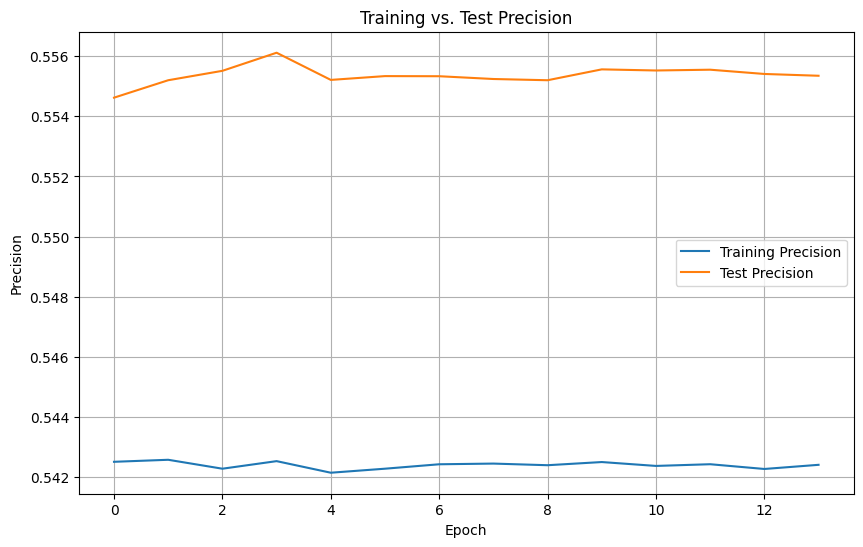

In [102]:
# Learning visualisation for the Deep Neural Network (DNN)
# The model is not actually training, as the precision and accuracy score are not improving on TRAIN/TEST with more Epochs

# Plotting accuracy
plt.figure(figsize=(10, 6))
plt.plot(best_history_nn['precision_10'], label='Training Precision')
plt.plot(best_history_nn['val_precision_10'], label='Test Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Training vs. Test Precision')
plt.legend()
plt.grid(True)
plt.show()

# 2) Different Decision rules to improve precision (varying threshold)

best model1 (clf_best): Decision Tree (max_depth=15)
best model2 (rf_best): Random Forest (n_estimators=200, max_depth=17)

## 2.1. Predicting probabilities (predict_proba), getting the distribution for probabilities, and new decision rules

In [103]:
# y_pred_test = best_lr.predict_proba(X_test)

# predicting probability instead of a lable

y_pred_test = clf_best.predict_proba(X_test)
y_pred_test_class1 = [k[1] for k in y_pred_test] # k[1] is the second element in the list of Class predictions

In [104]:
# example prediction of probabilities
y_pred_test

array([[0.51366425, 0.48633575],
       [0.51366425, 0.48633575],
       [0.51366425, 0.48633575],
       ...,
       [0.59356568, 0.40643432],
       [0.59356568, 0.40643432],
       [0.59356568, 0.40643432]])

In [105]:
y_pred_test_class1_df = pd.DataFrame(y_pred_test_class1, columns=['Class1_probability'])
y_pred_test_class1_df.head()

,Class1_probability
0,0.486336
1,0.486336
2,0.486336
3,0.486336
4,0.142857


In [106]:
# Mean prediction is 0.52, median is 0.58, 75% quantile is 0.75
y_pred_test_class1_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Class1_probability,29829.0,0.526287,0.284003,0.0,0.3875,0.583523,0.750392,1.0


In [107]:
# Unconditional probability of a positive growth is 55.5%
y_test.sum()/y_test.count()

0.5551979617151095

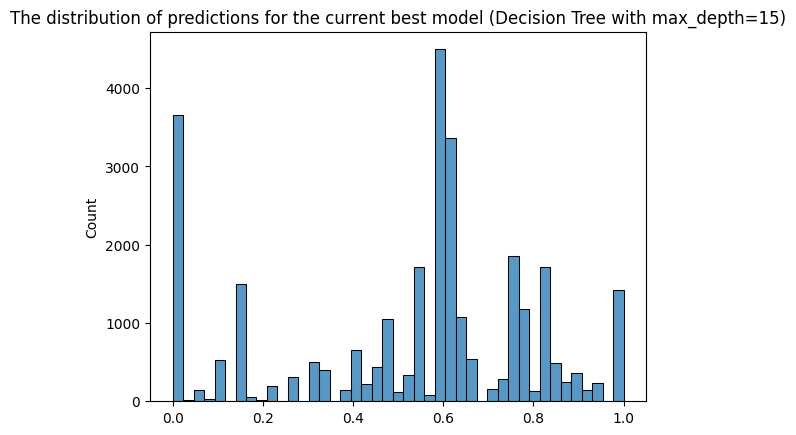

In [108]:
sns.histplot(y_pred_test_class1)

# Add a title
plt.title('The distribution of predictions for the current best model (Decision Tree with max_depth=15)')

# Show the plot
plt.show()

In [109]:
# tpr (True Positive Rate) vs. fpr (False Positive Rate) dataframe
# tp = True Positive
# tn = True Negative
# fp = False Positive
# fn = False Negative
# Decision Rule :  "y_pred>= Threshold" for Class "1"

# when only_even=True --> we'll have a step ==0.02 and leave only even records

def tpr_fpr_dataframe(y_true, y_pred, only_even=False):
    scores = []

    if only_even==False:
      thresholds = np.linspace(0, 1, 101) #[0, 0.01, 0.02, ...0.99,1.0]
    else:
      thresholds = np.linspace(0, 1, 51) #[0, 0.02, 0.04,  ...0.98,1.0]

    for t in thresholds:

        actual_positive = (y_true == 1)
        actual_negative = (y_true == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        if tp + fp > 0:
          precision = tp / (tp + fp)

        if tp + fn > 0:
          recall = tp / (tp + fn)

        if precision+recall > 0:
          f1_score = 2*precision*recall / (precision+recall)

        accuracy = (tp+tn) / (tp+tn+fp+fn)

        scores.append((t, tp, fp, fn, tn, precision, recall, accuracy, f1_score))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn','precision','recall', 'accuracy','f1_score']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores


In [110]:
df_scores = tpr_fpr_dataframe(y_test,
                              y_pred_test_class1,
                              only_even=True)

In [111]:
# full df_scores
df_scores

,threshold,tp,fp,fn,tn,precision,recall,accuracy,f1_score,tpr,fpr
0,0.00,16561,13268,0,0,0.555198,1.000000,0.555198,0.713990,1.000000,1.000000
1,0.02,14899,11280,1662,1988,0.569120,0.899644,0.566127,0.697192,0.899644,0.850166
2,0.04,14899,11280,1662,1988,0.569120,0.899644,0.566127,0.697192,0.899644,0.850166
3,0.06,14849,11256,1712,2012,0.568818,0.896625,0.565255,0.696058,0.896625,0.848357
4,0.08,14779,11232,1782,2036,0.568183,0.892398,0.563713,0.694306,0.892398,0.846548
5,0.10,14736,11188,1825,2080,0.568431,0.889801,0.563747,0.693704,0.889801,0.843232
6,0.12,14528,10927,2033,2341,0.570733,0.877242,0.565523,0.691546,0.877242,0.823560
7,0.14,14526,10926,2035,2342,0.570721,0.877121,0.565490,0.691500,0.877121,0.823485
8,0.16,13727,10284,2834,2984,0.571696,0.828875,0.560227,0.676674,0.828875,0.775098
9,0.18,13691,10226,2870,3042,0.572438,0.826701,0.560964,0.676466,0.826701,0.770727


In [112]:
df_scores[(df_scores.threshold>=0.5) & (df_scores.threshold<=0.8)]

,threshold,tp,fp,fn,tn,precision,recall,accuracy,f1_score,tpr,fpr
25,0.50,11631,8201,4930,5067,0.586476,0.702313,0.559791,0.639189,0.702313,0.618104
26,0.52,11628,8200,4933,5068,0.586443,0.702132,0.559724,0.639094,0.702132,0.618028
27,0.54,11359,8070,5202,5198,0.584642,0.685889,0.555064,0.631231,0.685889,0.608230
28,0.56,10397,7380,6164,5888,0.584857,0.627800,0.545945,0.605568,0.627800,0.556226
29,0.58,10359,7342,6202,5926,0.585221,0.625506,0.545945,0.604693,0.625506,0.553361
30,0.60,7706,5500,8855,7768,0.583523,0.465310,0.518757,0.517755,0.465310,0.414531
31,0.62,5756,4090,10805,9178,0.584603,0.347564,0.500654,0.435945,0.347564,0.308260
32,0.64,5652,4029,10909,9239,0.583824,0.341284,0.499212,0.430760,0.341284,0.303663
33,0.66,5041,3463,11520,9805,0.592780,0.304390,0.497704,0.402234,0.304390,0.261004
34,0.68,4860,3371,11701,9897,0.590451,0.293461,0.494720,0.392062,0.293461,0.254070


<Axes: title={'center': 'Precision vs. Recall for the Best Model (Decision Tree with max_depth=15)'}, xlabel='threshold'>

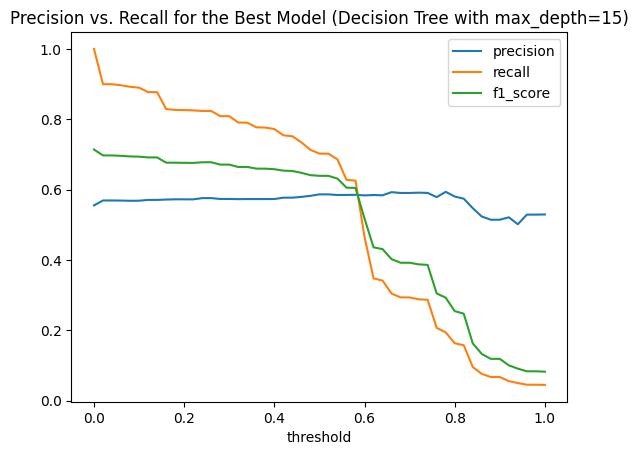

In [113]:
# Try to find high Precision score points

df_scores.plot.line(x='threshold',
                    y=['precision','recall', 'f1_score'],
                    title = 'Precision vs. Recall for the Best Model (Decision Tree with max_depth=15)')

## 2.2) [Code Snippet 6] Defining new columns with Predictions in new_df: pred7..pred10
* pred7 and pred8 are 2 decision rules for the Decision Tree (best model with max_depth=15)
* pred9 and pred10 are 2 decision rules for the Random Forest (second best model)

In [114]:
# adding Decision Tree predictors (clf_best) to the dataset for 2 new rules: Threshold = 0.66 and 0.78


y_pred_all = clf_best.predict_proba(X_all)
y_pred_all_class1 = [k[1] for k in y_pred_all] #list of predictions for class "1"
y_pred_all_class1_array = np.array(y_pred_all_class1) # (Numpy Array) np.array of predictions for class "1" , converted from a list

# defining a new prediction vector is easy now, as the dimensions will match
new_df['proba_pred7'] = y_pred_all_class1_array
new_df['pred7_clf_best_rule_66'] = (y_pred_all_class1_array >= 0.66).astype(int)

new_df['proba_pred8'] = y_pred_all_class1_array
new_df['pred8_clf_best_rule_78'] = (y_pred_all_class1_array >= 0.78).astype(int)

In [115]:
# adding Random Forest predictors (rf_best)
rf_best

RandomForestClassifier(max_depth=17, n_estimators=200, n_jobs=-1,
                       random_state=42)

In [116]:
# adding Random Forest predictors (rf_best) to the dataset for 2 new rules: Threshold = 0.66 and 0.78

y_pred_all = rf_best.predict_proba(X_all)
y_pred_all_class1 = [k[1] for k in y_pred_all] #list of predictions for class "1"
y_pred_all_class1_array = np.array(y_pred_all_class1) # (Numpy Array) np.array of predictions for class "1" , converted from a list

# defining a new prediction vector is easy now, as the dimensions will match
new_df['proba_pred9'] = y_pred_all_class1_array
new_df['pred9_rf_best_rule_55'] = (y_pred_all_class1_array >= 0.55).astype(int)

new_df['proba_pred10'] = y_pred_all_class1_array
new_df['pred10_rf_best_rule_60'] = (y_pred_all_class1_array >= 0.6).astype(int)

# TODO HA4 Q1: define new predictor for thresholds 0.51..0.54, 0.56..0.59

In [117]:
PREDICTIONS

['pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_snp',
 'pred3_manual_gdp_and_fastd',
 'pred4_manual_gdp_and_wti30d',
 'pred5_clf_10',
 'pred6_clf_best']

<Axes: >

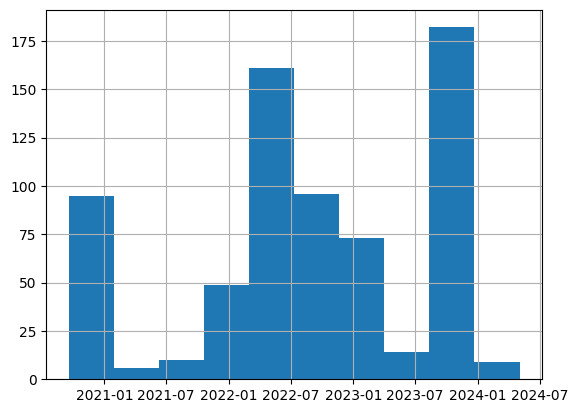

In [118]:
# When did it predict to trade for the "rare" prediction pred10? (only 2%)
new_df[(new_df.split=='test')&(new_df.pred10_rf_best_rule_60==1)].Date.hist()

In [119]:
new_df[(new_df.split=='test')&(new_df.pred10_rf_best_rule_60==1)].sort_values(by='Date')

,Open,High,Low,Close,Adj Close_x,Volume,Ticker,Year,Month,Weekday,...,pred6_clf_best,is_correct_pred6,proba_pred7,pred7_clf_best_rule_66,proba_pred8,pred8_clf_best_rule_78,proba_pred9,pred9_rf_best_rule_55,proba_pred10,pred10_rf_best_rule_60
5326,756.000000,759.599976,744.000000,744.000000,726.495850,85106.0,RMS.PA,2020,September,4,...,0,1,0.142857,0,0.142857,0,0.616821,1,0.616821,1
5327,276.000000,276.100006,269.600006,271.100006,256.523193,590993.0,OR.PA,2020,September,0,...,1,1,0.539062,0,0.539062,0,0.610240,1,0.610240,1
4823,47.689999,48.369999,47.570000,48.270000,47.062443,1151700.0,HDB,2020,September,1,...,1,1,0.539062,0,0.539062,0,0.604826,1,0.604826,1
5420,13.770000,13.810000,13.560000,13.590000,12.568239,7495000.0,INFY,2020,September,2,...,1,1,0.586812,0,0.586812,0,0.620527,1,0.620527,1
6298,155.300003,155.639999,151.830002,152.110001,143.006088,449500.0,SAP,2020,September,2,...,1,1,0.586812,0,0.586812,0,0.606076,1,0.606076,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3594,22.600000,23.049999,22.600000,22.740000,22.740000,86700.0,IDEXY,2024,May,2,...,0,1,0.440397,0,0.440397,0,0.601444,1,0.601444,1
7204,181.699997,183.429993,179.149994,180.070007,180.070007,622200.0,SAP,2024,May,2,...,0,1,0.440397,0,0.440397,0,0.609429,1,0.609429,1
7041,396.609985,402.320007,396.350006,398.579987,398.579987,2605000.0,BRK-B,2024,May,2,...,0,1,0.440397,0,0.440397,0,0.605517,1,0.605517,1
4057,268.149994,270.910004,266.709991,267.320007,267.320007,6119900.0,V,2024,May,2,...,0,1,0.440397,0,0.440397,0,0.604531,1,0.604531,1


In [120]:
# Pred 10: How many positive prediction per day (out of 33 stocks possible)
pred10_daily_positive_count = pd.DataFrame(new_df[(new_df.split=='test')&(new_df.pred10_rf_best_rule_60==1)].groupby('Date')['pred10_rf_best_rule_60'].count())

In [121]:
# Pred 9: How many positive prediction per day (out of 33 stocks possible)
pred9_daily_positive_count = pd.DataFrame(new_df[(new_df.split=='test')&(new_df.pred9_rf_best_rule_55==1)].groupby('Date')['pred9_rf_best_rule_55'].count())

In [122]:
# Unique trading days on Test (4 years)
new_df[(new_df.split=='test')].Date.nunique()

947

In [123]:
pred10_daily_positive_count

,pred10_rf_best_rule_60
Date,
2020-09-18,1
2020-09-21,1
2020-09-22,1
2020-09-23,6
2020-09-24,4
...,...
2023-11-13,1
2023-11-17,1
2024-01-08,1


array([[<Axes: title={'center': 'pred10_rf_best_rule_60'}>]], dtype=object)

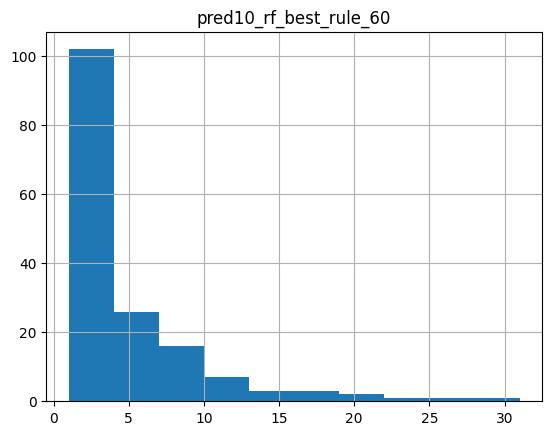

In [124]:
pred10_daily_positive_count.hist()

In [125]:
# 75% cases we have not more than 6 bets of $100
pred10_daily_positive_count.describe().T

,count,mean,std,min,25%,50%,75%,max
pred10_rf_best_rule_60,162.0,4.290123,4.998984,1.0,1.0,2.0,6.0,31.0


array([[<Axes: title={'center': 'pred9_rf_best_rule_55'}>]], dtype=object)

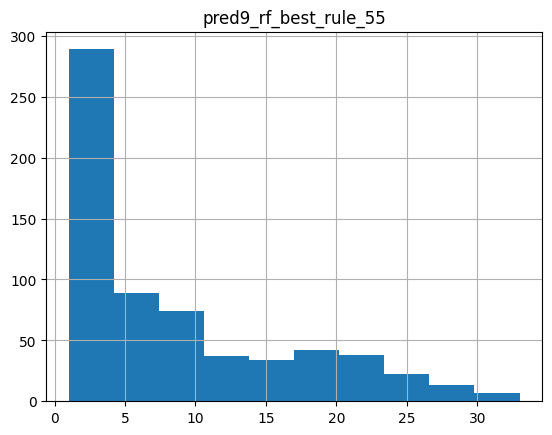

In [126]:
pred9_daily_positive_count.hist()

In [127]:
pred9_daily_positive_count.describe().T

,count,mean,std,min,25%,50%,75%,max
pred9_rf_best_rule_55,645.0,8.474419,7.903025,1.0,2.0,6.0,13.0,33.0


## 2.3) Agg. stats on ALL predictions

In [128]:
# let's review the Predictions:
PREDICTIONS, IS_CORRECT = get_predictions_correctness(new_df, to_predict=to_predict)


Prediction columns founded: ['pred0_manual_cci', 'pred1_manual_prev_g1', 'pred2_manual_prev_g1_and_snp', 'pred3_manual_gdp_and_fastd', 'pred4_manual_gdp_and_wti30d', 'pred5_clf_10', 'pred6_clf_best', 'pred7_clf_best_rule_66', 'pred8_clf_best_rule_78', 'pred9_rf_best_rule_55', 'pred10_rf_best_rule_60']
Created columns is_correct: ['is_correct_pred0', 'is_correct_pred1', 'is_correct_pred2', 'is_correct_pred3', 'is_correct_pred4', 'is_correct_pred5', 'is_correct_pred6', 'is_correct_pred7', 'is_correct_pred8', 'is_correct_pred9', 'is_correct_pred10']
Precision on TEST set for each prediction:
Prediction column:pred0_manual_cci , is_correct_column: is_correct_pred0
is_correct_pred0
1    455
0    344
Name: count, dtype: int64
is_correct_pred0
1    0.569462
0    0.430538
Name: count, dtype: float64
---------
Prediction column:pred1_manual_prev_g1 , is_correct_column: is_correct_pred1
is_correct_pred1
1    8621
0    6980
Name: count, dtype: int64
is_correct_pred1
1    0.552593
0    0.447407
Na

In [129]:
# Extract number from the prediction column

# Example string
example_string = "pred10_rf_best_rule_60"

# Split the string by '_'
parts = example_string.split('_')

# Extract the part with 'pred' and remove the 'pred' prefix
pred_number = parts[0].replace('pred', '')

# Print the result
print(pred_number)

# Print in one line
print(int(example_string.split('_')[0].replace('pred', '')))


10
10


In [130]:
# all predictions
PREDICTIONS

['pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_snp',
 'pred3_manual_gdp_and_fastd',
 'pred4_manual_gdp_and_wti30d',
 'pred5_clf_10',
 'pred6_clf_best',
 'pred7_clf_best_rule_66',
 'pred8_clf_best_rule_78',
 'pred9_rf_best_rule_55',
 'pred10_rf_best_rule_60']

In [131]:
# all predictions on MODELS (not-manual predictions)
PREDICTIONS_ON_MODELS = [p for p in PREDICTIONS if int(p.split('_')[0].replace('pred', ''))>=5]
PREDICTIONS_ON_MODELS

['pred5_clf_10',
 'pred6_clf_best',
 'pred7_clf_best_rule_66',
 'pred8_clf_best_rule_78',
 'pred9_rf_best_rule_55',
 'pred10_rf_best_rule_60']

In [132]:
# all predictions on Models - correctness
IS_CORRECT_ON_MODELS = [p for p in IS_CORRECT if int(p.replace('is_correct_pred', ''))>=5]
IS_CORRECT_ON_MODELS

['is_correct_pred5',
 'is_correct_pred6',
 'is_correct_pred7',
 'is_correct_pred8',
 'is_correct_pred9',
 'is_correct_pred10']

In [133]:
# predictions on models
# pred10_rf_best_rule_60: ONLY 2% of TEST cases predicted with high confidence of growth
new_df.groupby('split')[PREDICTIONS_ON_MODELS].agg(['count','sum','mean']).T

split                                 test          train    validation
pred5_clf_10           count  29829.000000  123458.000000  29388.000000
                       sum    25644.000000   98448.000000  27563.000000
                       mean       0.859700       0.797421      0.937900
pred6_clf_best         count  29829.000000  123458.000000  29388.000000
                       sum    19828.000000   78085.000000  21163.000000
                       mean       0.664722       0.632482      0.720124
pred7_clf_best_rule_66 count  29829.000000  123458.000000  29388.000000
                       sum     8504.000000   31404.000000   6415.000000
                       mean       0.285092       0.254370      0.218286
pred8_clf_best_rule_78 count  29829.000000  123458.000000  29388.000000
                       sum     5419.000000   23345.000000   3751.000000
                       mean       0.181669       0.189093      0.127637
pred9_rf_best_rule_55  count  29829.000000  123458.000000  29388.000000
                       sum     5466.000000   63447.000000  17685.000000
                       mean       0.183244       0.513916      0.601776
pred10_rf_best_rule_60 count  29829.000000  123458.000000  29388.000000
                       sum      695.000000   48759.000000  14427.000000
                       mean       0.023299       0.394944      0.490915

In [134]:
# 10 predictions stats (check TEST set)
new_df.groupby('split')[PREDICTIONS].agg(['count','sum','mean']).T

split                                       test          train    validation
pred0_manual_cci             count  29829.000000  123458.000000  29388.000000
                             sum      799.000000    3162.000000    875.000000
                             mean       0.026786       0.025612      0.029774
pred1_manual_prev_g1         count  29829.000000  123458.000000  29388.000000
                             sum    15601.000000   62117.000000  15585.000000
                             mean       0.523015       0.503143      0.530318
pred2_manual_prev_g1_and_snp count  29829.000000  123458.000000  29388.000000
                             sum    10455.000000   41609.000000  10902.000000
                             mean       0.350498       0.337030      0.370968
pred3_manual_gdp_and_fastd   count  29829.000000  123458.000000  29388.000000
                             sum    29822.000000  107032.000000  29388.000000
                             mean       0.999765       0.866951      1.000000
pred4_manual_gdp_and_wti30d  count  29829.000000  123458.000000  29388.000000
                             sum        0.000000    5673.000000      0.000000
                             mean       0.000000       0.045951      0.000000
pred5_clf_10                 count  29829.000000  123458.000000  29388.000000
                             sum    25644.000000   98448.000000  27563.000000
                             mean       0.859700       0.797421      0.937900
pred6_clf_best               count  29829.000000  123458.000000  29388.000000
                             sum    19828.000000   78085.000000  21163.000000
                             mean       0.664722       0.632482      0.720124
pred7_clf_best_rule_66       count  29829.000000  123458.000000  29388.000000
                             sum     8504.000000   31404.000000   6415.000000
                             mean       0.285092       0.254370      0.218286
pred8_clf_best_rule_78       count  29829.000000  123458.000000  29388.000000
                             sum     5419.000000   23345.000000   3751.000000
                             mean       0.181669       0.189093      0.127637
pred9_rf_best_rule_55        count  29829.000000  123458.000000  29388.000000
                             sum     5466.000000   63447.000000  17685.000000
                             mean       0.183244       0.513916      0.601776
pred10_rf_best_rule_60       count  29829.000000  123458.000000  29388.000000
                             sum      695.000000   48759.000000  14427.000000
                             mean       0.023299       0.394944      0.490915

# 3) Trading Simulations

* create simulation 1 features: like "sim1_pred0" ... "sim1_predLast"

## 3.1) Investing $100 on every positive prediction
* fees = 0.1% for each buy and sell operation ==> 0.2% for buy+sell operation

In [135]:
# current prediction
pred = 'pred6_clf_best'

In [136]:
# Total Number of Investment Opportunities
new_df[new_df.split=='test'].Close.count()

29829

In [137]:
# Total Number of Days (~4 years of trading)
new_df[new_df.split=='test'].Date.nunique()

947

In [138]:
# check actual future growth with 'growth_future_5d', correctness of the prediction with 'is_positive_growth_5d_future'
TO_PREDICT

['growth_future_5d', 'is_positive_growth_5d_future']

In [139]:
new_df[['growth_future_5d', to_predict,pred]]

,growth_future_5d,is_positive_growth_5d_future,pred6_clf_best
3490,0.963003,0,1
3491,0.971143,0,1
3492,0.929709,0,1
3493,0.980114,0,1
3494,1.007291,1,1
...,...,...,...
5422,NaN,0,0
5423,NaN,0,0
5424,NaN,0,0
5425,NaN,0,0


In [140]:
# GROSS REVENUE: ONLY when current_prediction equals to 1: invest $100 into that stock (buy), and sell in 1week (sell)
new_df['sim1_gross_rev_pred6'] = new_df[pred] * 100 * (new_df['growth_future_5d']-1)

In [141]:
# FEES: 0.1% for each operation , 0.2% for buy+sell ONLY when current_prediction equals to one
new_df['sim1_fees_pred6'] = -new_df[pred] * 100 * 0.002

In [142]:
# NET REVENUE: GROSS_REVENUE + FEES
new_df['sim1_net_rev_pred6'] = new_df['sim1_gross_rev_pred6'] + new_df['sim1_fees_pred6']

In [143]:
COLUMNS_FIN_RESULT = ['Date','Ticker','Close']+TO_PREDICT+ [pred,  'sim1_gross_rev_pred6','sim1_fees_pred6','sim1_net_rev_pred6']
new_df[(new_df.split=='test')&(new_df[pred]==1)][COLUMNS_FIN_RESULT]

,Date,Ticker,Close,growth_future_5d,is_positive_growth_5d_future,pred6_clf_best,sim1_gross_rev_pred6,sim1_fees_pred6,sim1_net_rev_pred6
8702,2020-09-21,MSFT,202.539993,1.034067,1,1,3.406741,-0.2,3.206741
8703,2020-09-22,MSFT,207.419998,0.999228,0,1,-0.077153,-0.2,-0.277153
8704,2020-09-23,MSFT,200.589996,1.048557,1,1,4.855687,-0.2,4.655687
8705,2020-09-24,MSFT,203.190002,1.045623,1,1,4.562258,-0.2,4.362258
8706,2020-09-25,MSFT,207.820007,0.992157,0,1,-0.784335,-0.2,-0.984335
...,...,...,...,...,...,...,...,...,...
5417,2024-04-23,LT.NS,3610.149902,0.995610,0,1,-0.439036,-0.2,-0.639036
5418,2024-04-24,LT.NS,3634.850098,0.990275,0,1,-0.972532,-0.2,-1.172532
5419,2024-04-25,LT.NS,3652.300049,0.958245,0,1,-4.175451,-0.2,-4.375451
5420,2024-04-26,LT.NS,3605.199951,0.960640,0,1,-3.935979,-0.2,-4.135979


In [144]:
# DAILY INVESTMENTS COUNT
filter_test_and_positive_pred = (new_df.split=='test')&(new_df[pred]==1)
df_investments_count_daily = pd.DataFrame(new_df[filter_test_and_positive_pred].groupby('Date')[pred].count())
sim1_avg_investments_per_day = df_investments_count_daily[pred].quantile(0.75)  # 75% case - how many $100 investments per day do we have?
print(sim1_avg_investments_per_day)

33.0


In [145]:
# Distribution: how many times do we trade daily (for the current Prediction)?
df_investments_count_daily.describe().T

,count,mean,std,min,25%,50%,75%,max
pred6_clf_best,809.0,24.509271,11.989175,1.0,13.0,32.0,33.0,33.0


In [146]:
new_df[(new_df.split=='test')&(new_df[pred]==1)][['sim1_gross_rev_pred6','sim1_fees_pred6','sim1_net_rev_pred6']].sum()

sim1_gross_rev_pred6    14477.431798
sim1_fees_pred6         -3965.600000
sim1_net_rev_pred6      10511.831798
dtype: float64

### 3.1.2 Calculate fin. results for all fields
* Simplified and approximate calculation

In [147]:
# Calculate fin. result for ALL predictions (manual and produced by models)

sim1_results = [] # results in Array

# Iterate over all predictions
for pred in PREDICTIONS:
  print(f'Calculating sumulation for prediction {pred}:')
  print(f"    Count times of investment {len(new_df[(new_df.split=='test')&(new_df[pred]==1)])} out of {len(new_df[(new_df.split=='test')])} TEST records")

  # Prefix: e.g. pred1 or pred10
  pred_prefix= pred.split('_')[0]

  # Fin. result columns: define new records for EACH positive prediction
  new_df['sim1_gross_rev_'+pred_prefix] = new_df[pred] * 100 * (new_df['growth_future_5d']-1)
  new_df['sim1_fees_'+pred_prefix] = -new_df[pred] * 100 * 0.002
  new_df['sim1_net_rev_'+pred_prefix] = new_df['sim1_gross_rev_'+pred_prefix] + new_df['sim1_fees_'+pred_prefix]

  # calculate agg. results for each PREDICTION columns (pred) on TEST
  filter_test_and_positive_pred = (new_df.split=='test')&(new_df[pred]==1) # filter records on TEST set, when current prediction is 1 (we invest $100 for 1 week ahead - 5 periods)
  sim1_count_investments = len(new_df[filter_test_and_positive_pred])
  sim1_gross_rev = new_df[filter_test_and_positive_pred]['sim1_gross_rev_'+pred_prefix].sum()
  sim1_fees = new_df[filter_test_and_positive_pred]['sim1_fees_'+pred_prefix].sum()
  sim1_net_rev = new_df[filter_test_and_positive_pred]['sim1_net_rev_'+pred_prefix].sum()

  if sim1_gross_rev>0:
    sim1_fees_percentage = -sim1_fees/sim1_gross_rev
  else:
    sim1_fees_percentage = None

  if sim1_count_investments>0:
    sim1_average_net_revenue = sim1_net_rev/sim1_count_investments
  else:
    sim1_average_net_revenue = None

  # APPROXIMATE CAPITAL REQUIRED and CAGR Calculation
  df_investments_count_daily = pd.DataFrame(new_df[filter_test_and_positive_pred].groupby('Date')[pred].count())
  sim1_avg_investments_per_day = df_investments_count_daily[pred].mean()
  sim1_q75_investments_per_day = df_investments_count_daily[pred].quantile(0.75)  # 75% case - how many $100 investments per day do we have?
  # df_investments_count_daily[pred].mean()
  sim1_capital = 100 * 5 * sim1_q75_investments_per_day # 5 days in a row with positive predictions
  # CAGR: average growth per year. E.g. if you have 1.5 return (50% growth in 4 years) --> (1.5)**(1/4) = 1.106 or 10.6% average
  sim1_CAGR = ((sim1_capital+sim1_net_rev)/sim1_capital)**(1/4)

  # append to DF
  sim1_results.append((pred,sim1_count_investments,sim1_gross_rev,sim1_fees,sim1_net_rev,sim1_fees_percentage,sim1_average_net_revenue,sim1_avg_investments_per_day,sim1_capital,sim1_CAGR))


  # output for all predictions with some positive predictions
  if  sim1_count_investments>1:
    print(f"    Financial Result: \n {new_df[filter_test_and_positive_pred][['sim1_gross_rev_'+pred_prefix,'sim1_fees_'+pred_prefix,'sim1_net_rev_'+pred_prefix]].sum()}")
    print(f"        Count Investments in 4 years (on TEST): {sim1_count_investments}")
    print(f"        Gross Revenue: ${int(sim1_gross_rev)}")
    print(f"        Fees (0.2% for buy+sell): ${int(-sim1_fees)}")
    print(f"        Net Revenue: ${int(sim1_net_rev)}")
    print(f"        Fees are {int(-100.0*sim1_fees/sim1_gross_rev)} % from Gross Revenue")
    print(f"        Capital Required : ${int(sim1_capital)} (Vbegin)")
    print(f"        Final value (Vbegin + Net_revenue) : ${int(sim1_capital + sim1_net_rev)} (Vfinal)")

    print(f"        Average CAGR on TEST (4 years) : {np.round(sim1_CAGR,3)}, or {np.round(100.0*(sim1_CAGR-1),1)}% ")

    print(f"        Average daily stats: ")
    print(f"            Average net revenue per investment: ${np.round(sim1_net_rev/sim1_count_investments,2)} ")
    print(f"            Average investments per day: {int(np.round(sim1_avg_investments_per_day))} ")
    print(f"            Q75 investments per day: {int(np.round(sim1_q75_investments_per_day))} ")
    print('=============================================+')


# results in a DataFrame from an Array
columns_simulation = ['prediction', 'sim1_count_investments', 'sim1_gross_rev', 'sim1_fees', 'sim1_net_rev', 'sim1_fees_percentage','sim1_average_net_revenue','sim1_avg_investments_per_day','sim1_capital','sim1_CAGR']

df_sim1_results = pd.DataFrame(sim1_results,columns=columns_simulation)

Calculating sumulation for prediction pred0_manual_cci:
    Count times of investment 799 out of 29829 TEST records
    Financial Result: 
 sim1_gross_rev_pred0    309.04589
sim1_fees_pred0        -159.80000
sim1_net_rev_pred0      149.84589
dtype: float64
        Count Investments in 4 years (on TEST): 799
        Gross Revenue: $309
        Fees (0.2% for buy+sell): $159
        Net Revenue: $149
        Fees are 51 % from Gross Revenue
        Capital Required : $1000 (Vbegin)
        Final value (Vbegin + Net_revenue) : $1149 (Vfinal)
        Average CAGR on TEST (4 years) : 1.036, or 3.6% 
        Average daily stats: 
            Average net revenue per investment: $0.19 
            Average investments per day: 2 
            Q75 investments per day: 2 
=============================================+
Calculating sumulation for prediction pred1_manual_prev_g1:
    Count times of investment 15601 out of 29829 TEST records
    Financial Result: 
 sim1_gross_rev_pred1    6913.217124


In [148]:
df_sim1_results['sim1_growth_capital_4y'] = (df_sim1_results.sim1_net_rev+df_sim1_results.sim1_capital) / df_sim1_results.sim1_capital

In [149]:
# final comparison
df_sim1_results

,prediction,sim1_count_investments,sim1_gross_rev,sim1_fees,sim1_net_rev,sim1_fees_percentage,sim1_average_net_revenue,sim1_avg_investments_per_day,sim1_capital,sim1_CAGR,sim1_growth_capital_4y
0,pred0_manual_cci,799,309.045890,-159.8,149.845890,0.517075,0.187542,1.866822,1000.0,1.035523,1.149846
1,pred1_manual_prev_g1,15601,6913.217124,-3120.2,3812.817124,0.451338,0.244396,16.526483,11000.0,1.077237,1.346620
2,pred2_manual_prev_g1_and_snp,10455,4213.424501,-2091.0,2139.624501,0.496271,0.204651,21.918239,13000.0,1.038826,1.164587
3,pred3_manual_gdp_and_fastd,29822,14893.285316,-5964.4,8961.885316,0.400476,0.300513,31.491024,16500.0,1.114555,1.543145
4,pred4_manual_gdp_and_wti30d,0,0.000000,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
5,pred5_clf_10,25644,15578.953119,-5128.8,10483.153119,0.329213,0.408796,31.311355,16500.0,1.130843,1.635343
6,pred6_clf_best,19828,14477.431798,-3965.6,10511.831798,0.273916,0.530151,24.509271,16500.0,1.131143,1.637081
7,pred7_clf_best_rule_66,8504,6977.651882,-1700.8,5276.851882,0.243750,0.620514,18.608315,16000.0,1.073858,1.329803
8,pred8_clf_best_rule_78,5419,4659.937647,-1083.8,3576.137647,0.232578,0.659926,15.891496,14500.0,1.056658,1.246630
9,pred9_rf_best_rule_55,5466,5150.760675,-1093.2,4064.360675,0.212240,0.743571,8.474419,6500.0,1.129100,1.625286


In [150]:
# Create the scatter plot
fig = px.scatter(
    df_sim1_results.dropna(),
    x='sim1_avg_investments_per_day',
    y='sim1_CAGR',
    size='sim1_growth_capital_4y',  # Use the 'size' parameter for sim1_CAGR
    text='prediction',
    title='Compound Annual Growth vs. Time spent (Average investments per day)',
    labels={'sim1_capital': 'Initial Capital Requirement', 'growth_capital_4y': '4-Year Capital Growth'}
)

# Update the layout to improve readability of the annotations
fig.update_traces(textposition='top center')

# Show the plot
fig.show()